# Multi-class Classification : Sign language for english alphabet

Using the [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset, which contains 28x28 images of hands depicting the 26 letters of the English alphabet.

Let's get started!

In [1]:
# Importing required libraries
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

Download the training and test sets :

In [2]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

C:\Users\Admin\anaconda3\lib\site-packages\gdown\cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: C:\Users\Admin\sign_mnist_train.csv

  0%|          | 0.00/83.3M [00:00<?, ?B/s]
  1%|          | 524k/83.3M [00:00<01:41, 814kB/s]
  1%|1         | 1.05M/83.3M [00:00<01:06, 1.24MB/s]
  3%|2         | 2.10M/83.3M [00:01<00:33, 2.44MB/s]
  4%|3         | 3.15M/83.3M [00:01<00:23, 3.43MB/s]
  5%|5         | 4.19M/83.3M [00:01<00:18, 4.19MB/s]
  6%|6         | 5.24M/83.3M [00:01<00:16, 4.75MB/s]
  8%|7         | 6.29M/83.3M [00:01<00:16, 4.69MB/s]
  9%|8         | 7.34M/83.3M [00:02<00:15, 5.01MB/s]
 10%|#         | 8.39M/83.3M [00:02<00:14, 5.24MB/s]
 11%|#1        | 9.44M/83.3M [00:02<00:13, 5.40MB/s]
 13%|#2        | 10.5M/83.3M [00:02<00:13, 5.50MB/s]
 14%|#3        | 11.5M/83.3M 

Define some globals with the path to both files you just downloaded:

In [3]:
TRAINING_FILE = 'C:\\Users\\Admin\\sign_mnist_train.csv'
VALIDATION_FILE = 'C:\\Users\\Admin\\sign_mnist_test.csv'

In [4]:

with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")


  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

As we can see, each file includes a header (the first line) and each subsequent data point is represented.

The first value is the label (the numeric representation of each letter) and the other values are the value of each pixel of the image. Remember that the original images have a resolution of 28x28.

 ## Parsing the dataset



In [5]:

def parse_data_from_input(filename):
  with open(filename) as file:
    # Using csv.reader, passing in the appropriate delimiter
    data = np.loadtxt(filename, delimiter=',', skiprows=1)
    labels = data[:,0].astype(int).reshape(-1)
    images = data[:,1:].astype(float).reshape(-1, 28, 28)

    return images, labels

In [6]:
# Testing function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: int32
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: int32


## Visualizing the numpy arrays


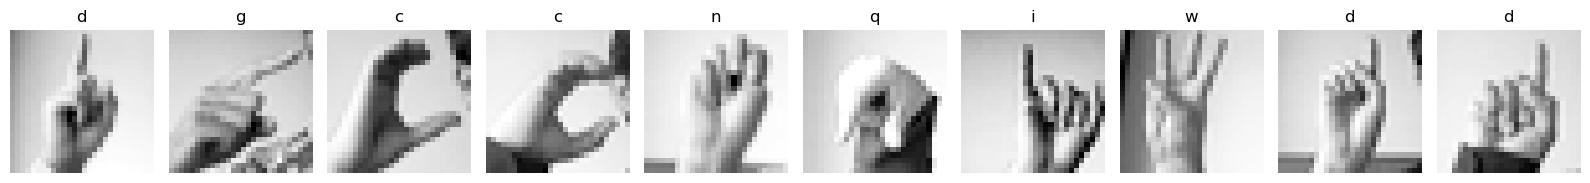

In [7]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

## Creating the generators for the CNN

In [8]:
# train_val_generators
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  
  training_images = np.expand_dims(training_images, axis=3)
  validation_images = np.expand_dims(validation_images, axis=3)

  train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=.2,
    zoom_range=.2,
    rotation_range=40,
    fill_mode='nearest',
    horizontal_flip=True
      )

  # Pass in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32)


  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale=1./255.)

  # Pass in the appropriate arguments to the flow method
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32)

  return train_generator, validation_generator

In [9]:
# Test generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


## Creating the CNN Model

In [10]:
def create_model():
  # Define the model
  model= tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    # 26 classes
    tf.keras.layers.Dense(26, activation='softmax')
  ])


  model.compile(optimizer = tf.optimizers.Adam(),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [11]:
# Save model
model = create_model()

# Train model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 [==============================] - 59s 67ms/step - loss: 1.8358 - accuracy: 0.4256 - val_loss: 0.8639 - val_accuracy: 0.6785
Epoch 2/15
858/858 [==============================] - 61s 71ms/step - loss: 0.7121 - accuracy: 0.7579 - val_loss: 0.5237 - val_accuracy: 0.8178
Epoch 3/15
858/858 [==============================] - 60s 70ms/step - loss: 0.3996 - accuracy: 0.8641 - val_loss: 0.4077 - val_accuracy: 0.8624
Epoch 4/15
858/858 [==============================] - 60s 70ms/step - loss: 0.2464 - accuracy: 0.9186 - val_loss: 0.2440 - val_accuracy: 0.9353
Epoch 5/15
858/858 [==============================] - 60s 70ms/step - loss: 0.1814 - accuracy: 0.9412 - val_loss: 0.3747 - val_accuracy: 0.8805
Epoch 6/15
858/858 [==============================] - 60s 70ms/step - loss: 0.1362 - accuracy: 0.9555 - val_loss: 0.2261 - val_accuracy: 0.9292
Epoch 7/15
858/858 [==============================] - 65s 76ms/step - loss: 0.1040 - accuracy: 0.9661 - val_loss: 0.3264 - val_accuracy:

Training history:

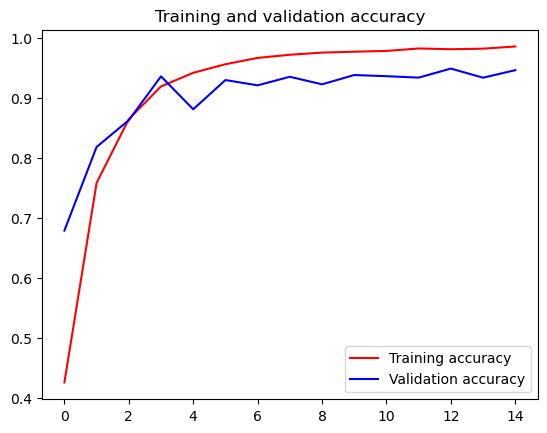

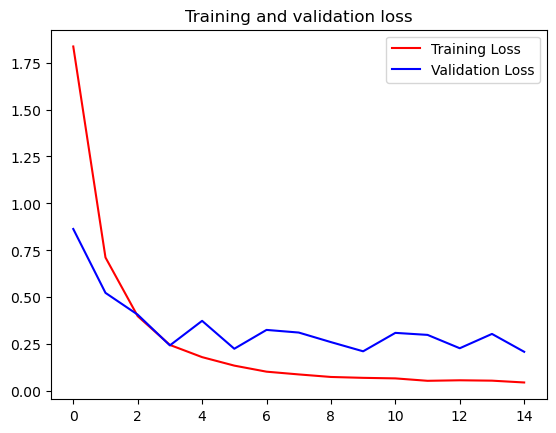

In [12]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()